In [2]:
# https://github.com/christophschuhmann/improved-aesthetic-predictor/blob/main/simple_inference.py
import torch
import pytorch_lightning as pl
import torch.nn as nn

import clip
from PIL import Image
import torch.nn.functional as F
import glob
import os
import matplotlib.pyplot as plt

In [3]:
# if you changed the MLP architecture during training, change it also here:
class MLP(pl.LightningModule):
    def __init__(self, input_size, xcol='emb', ycol='avg_rating'):
        super().__init__()
        self.input_size = input_size
        self.xcol = xcol
        self.ycol = ycol
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            #nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 16),
            #nn.ReLU(),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
            x = batch[self.xcol]
            y = batch[self.ycol].reshape(-1, 1)
            x_hat = self.layers(x)
            loss = F.mse_loss(x_hat, y)
            return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

def normalized(a, axis=-1, order=2):
    import numpy as np  # pylint: disable=import-outside-toplevel

    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)


anime_0
acertain_0.png: 6.42066764831543
animagine_xl_31_0.png: 5.450806617736816
anime_pastel_dream_0.png: 6.776700019836426
anythingv5_0.png: 6.531778335571289
dall_e_2_0.png: 5.446354866027832
dall_e_3_0.png: 6.741344451904297
sd15_0.png: 5.135190963745117
sd21_0.png: 5.867609977722168
sdxl_0.png: 6.430964946746826

anime_1
acertain_1.png: 6.175798416137695
animagine_xl_31_1.png: 5.836274147033691
anime_pastel_dream_1.png: 6.430553436279297
anythingv5_1.png: 6.553325176239014
dall_e_2_1.png: 5.358451843261719
dall_e_3_1.png: 6.970691680908203
sd15_1.png: 5.843155860900879
sd21_1.png: 5.691109657287598
sdxl_1.png: 6.6290059089660645

real_0
acertain_0.png: 5.177091598510742
animagine_xl_31_0.png: 4.6853437423706055
anime_pastel_dream_0.png: 5.506474494934082
anythingv5_0.png: 5.339964866638184
dall_e_2_0.png: 4.51594352722168
dall_e_3_0.png: 5.287834167480469
sd15_0.png: 5.404652118682861
sd21_0.png: 5.338715076446533
sdxl_0.png: 5.283657073974609

real_1
acertain_1.png: 5.6191997528

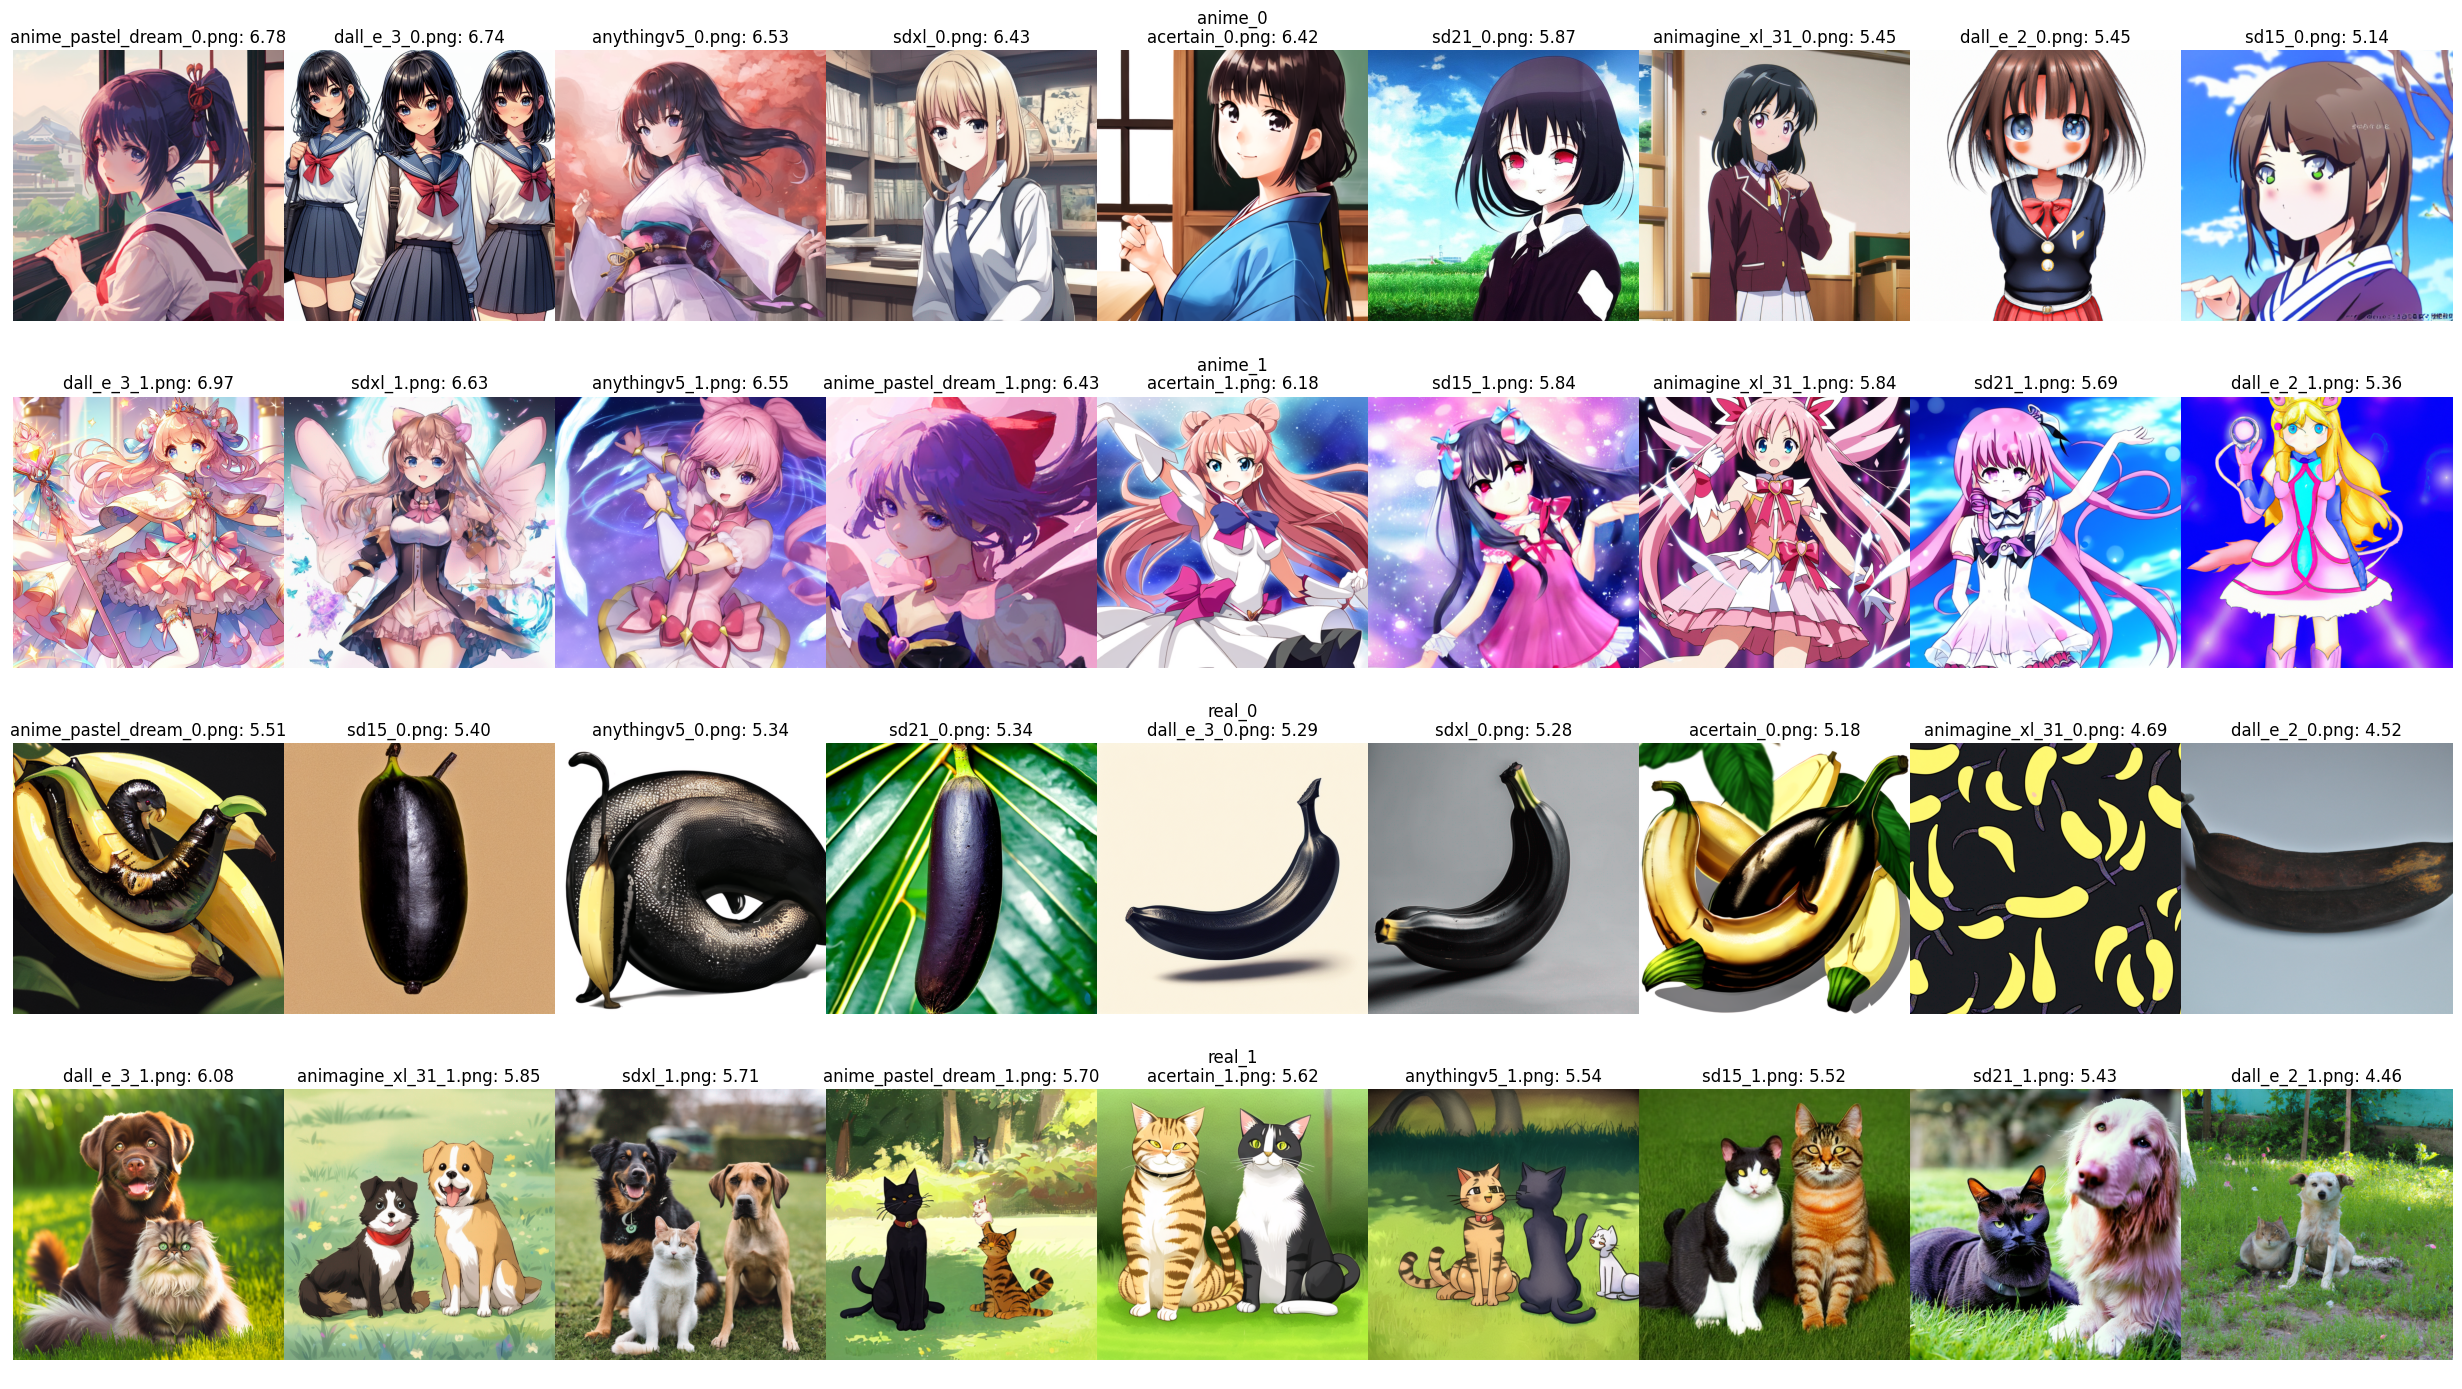

In [5]:
model = MLP(768)  # CLIP embedding dim is 768 for CLIP ViT L 14

s = torch.load("sac+logos+ava1-l14-linearMSE.pth")   # load the model you trained previously or the model available in this repo

model.load_state_dict(s)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()
model2, preprocess = clip.load("ViT-L/14", device=device)  #RN50x64   


score_data = {}
image_root_dir = "aesthetics_toy_images"
subdirs = sorted(glob.glob(f"{image_root_dir}/*"))
for subdir in subdirs:
    for i in range(2):
        subdir_key = f"{os.path.basename(subdir)}_{i}"
        print(subdir_key)
        files = sorted(glob.glob(subdir+f"/*{i}.png"))
        score_data[subdir_key] = {}
        for file in files:
            pil_image = Image.open(file)
            image = preprocess(pil_image).unsqueeze(0).to(device)
            with torch.no_grad():
                image_features = model2.encode_image(image)

                im_emb_arr = normalized(image_features.cpu().detach().numpy() )

                prediction = model(torch.from_numpy(im_emb_arr).to(device).type(torch.cuda.FloatTensor))
                score_data[subdir_key][os.path.basename(file)] = prediction.item()

            print(f'{os.path.basename(file)}: {prediction.item()}')
        print()

# Plot
fig, axes = plt.subplots(len(score_data), 1, figsize=(25, 3.5 * len(score_data)))

# 各ケースごとにスコアを降順ソートして画像を表示
for i, (case, scores) in enumerate(score_data.items()):
    sorted_scores = sorted(scores.items(), key=lambda item: item[1], reverse=True)
    images = [Image.open(os.path.join(image_root_dir, case.split("_")[0], img)) for img, score in sorted_scores]
    filenames = [img for img, score in sorted_scores]
    scores = [score for img, score in sorted_scores]
    
    ax = axes[i] if len(score_data) > 1 else axes
    for j, (image, filename, score) in enumerate(zip(images, filenames, scores)):
        ax_sub = ax.inset_axes([j/len(images), 0, 1/len(images), 1], transform=ax.transAxes)
        ax_sub.imshow(image)
        ax_sub.set_title(f'{filename}: {score:.2f}')
        ax_sub.axis('off')
    ax.set_title(case)
    ax.axis('off')

plt.tight_layout()
plt.savefig("aesthetic_score_predictor.png")
plt.show()    
